In [10]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time

b2.defaultclock.dt = 0.10 * b2.ms

from brian2 import *




In [38]:
def nmda_by_x(x_rate, w_pos):
    
    start_scope()
    #w_pos = 1.9
    N_Excit=384
    N_Inhib=96
    weight_scaling_factor=5.33
    t_stimulus_start=100 * b2.ms
    t_stimulus_duration=9999 * b2.ms
    coherence_level=0.
    stimulus_update_interval=30 * b2.ms
    mu0_mean_stimulus_Hz=250.
    stimulus_std_Hz=20.
    N_extern=1000
    firing_rate_extern=9.8 * b2.Hz
    f_Subpop_size=0.25  # .15 in publication [1]                     
    max_sim_time=1000. * b2.ms 
    stop_condition_rate=None

    monitored_subset_size=512, 
    E_leak_excit = -70.0 * b2.mV

    print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
    t_stimulus_end = t_stimulus_start + t_stimulus_duration

    N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
    N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
    N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

    Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
    G_leak_excit = 25.0 * b2.nS  # leak conductance
    E_leak_excit = -70.0 * b2.mV  # reversal potential   #######################################################
    v_spike_thr_excit = -50.0 * b2.mV  # spike condition
    v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
    t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

    # specify the inhibitory interneurons:
    # N_Inhib = 200
    Cm_inhib = 0.2 * b2.nF
    G_leak_inhib = 20.0 * b2.nS
    E_leak_inhib = -90.0 * b2.mV
    v_spike_thr_inhib = -50.0 * b2.mV
    v_reset_inhib = -60.0 * b2.mV
    t_abs_refract_inhib = 1.0 * b2.ms

    # specify the AMPA synapses
    E_AMPA = 0.0 * b2.mV
    tau_AMPA = 2.5 * b2.ms

    # specify the GABA synapses
    E_GABA = -70.0 * b2.mV
    tau_GABA = 5.0 * b2.ms

    # specify the NMDA synapses
    E_NMDA = 0.0 * b2.mV
    tau_NMDA_s = 100.0 * b2.ms
    tau_NMDA_x = 2. * b2.ms
    alpha_NMDA = 0.5 * b2.kHz

    # projections from the external population
    g_AMPA_extern2inhib = 1.62 * b2.nS
    g_AMPA_extern2excit = 2.1 * b2.nS

    # projectsions from the inhibitory populations
    g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
    g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

    # projections from the excitatory population
    g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
    g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
    g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
    g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

    # weights and "adjusted" weights.
    w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
    # We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
    w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
    w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
    # other weights are 1
    # print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))A
    # Define the inhibitory population



    excit_lif_dynamics = """
            s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
            dv/dt = (
            - G_leak_excit * (v-E_leak_excit)
            - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
            - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
            - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
            )/Cm_excit : volt (unless refractory)
            ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
            ds_GABA/dt = -s_GABA/tau_GABA : 1
            ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
            dx/dt = -x/tau_NMDA_x : 1
        """
    
    excit_lif_dynamics_nmda = """
            s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
            dv/dt = (
            - G_leak_excit * (v-E_leak_excit)
            - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
            - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
            - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
            )/Cm_excit : volt (unless refractory)
            ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
            ds_GABA/dt = -s_GABA/tau_GABA : 1
            ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
            dx/dt = -x/tau_NMDA_x : 1
        """


    one_neuron = NeuronGroup(1, model=excit_lif_dynamics_nmda,
                            threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                            refractory=t_abs_refract_excit, method="rk2")

    one_neuron.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=one_neuron.N) * b2.mV




    # network parameters
    N_E = 1000
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 10 * ms
    theta = 1 * mV
    V_r = 0 * mV
    tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV
    D = 1.5 * ms
    nu_ext = 10 *Hz
    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    defaultclock.dt = 0.1 * ms

    Poisson_NE = 1000
    g = 1

    #w_pos= 1.9



    # with and without NMDA 와 비교하기 
    exc_poisson_input = PoissonInput(
            target=one_neuron, target_var="s_AMPA", N=N_E, rate=1*nu_ext, weight= w_ext2excit)       

    inh_poisson_input = PoissonInput(
            target=one_neuron, target_var="s_GABA", N=N_I, rate=1*nu_ext, weight= w_ext2inhib)

    nmda_poisson_input = PoissonInput(
            target=one_neuron, target_var="x", N=1, rate= x_rate*Hz, weight= 1 )

    #NDMA input 
    sNMDA_A_total = []

    @network_operation()
    def update_nmda_sum():
            sum_sNMDA_A = 300*sum(one_neuron.s_NMDA)

            #sum_sNMDA_A = 100

            # note the _ at the end of s_NMDA_total_ disables unit checking
            one_neuron.s_NMDA_total_ = (w_pos * sum_sNMDA_A)  ## 자기 자신의 nmda input 만을 받는다. 
            sNMDA_A_total.append(sum_sNMDA_A)


    # set a self-recurrent synapse to introduce a delay when updating the intermediate
    # gating variable x

    syn_x_A2A = Synapses(one_neuron, one_neuron, on_pre="x += 1.", delay=0.5 * b2.ms)
    syn_x_A2A.connect(j="i")

    rmp_monitor = StateMonitor(one_neuron, 'v', record = 0)

    x_monitor = StateMonitor(one_neuron, 'x', record = 0)
    s_monitor = StateMonitor(one_neuron, 's_NMDA', record = 0)


    rmp_in_mV = 1000*(rmp_monitor.v[0])

    rmp_in_mV = 1000*(rmp_monitor.v[0])




    run(1200*ms, report='text')

    time_in_ms = (rmp_monitor.t/ms)/1000
    rmp_in_mV = 1000*(rmp_monitor.v[0])

    fig, ax = plt.subplots(1, figsize=(18, 6))

    ax.plot(time_in_ms, rmp_in_mV,linewidth=2) 
    ax.set_ylim([-75, -55])
    ax.set_title('w_pos = ' + str(w_pos))

    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



    ax.set_xlabel('time (s)')
    ax.set_ylabel('membrane potential (mV)')
    matplotlib.rcParams.update({'font.size': 25})
    plt.show()

    ###########################################--------------
"""






    ax[1].plot(time_in_ms, x_monitor.x[0],linewidth=2 )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)



    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('x')



    ###########################################--------------
    ax[2].plot(time_in_ms, s_monitor.s_NMDA[0],linewidth=2 )

    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)



    ax[2].set_xlabel('time (s)')
    ax[2].set_ylabel('nmda')


    #ax.set_xlim([25, 50])
    #ax.set_ylim([-100, -70])
    plt.rcParams.update({'font.size': 12})



    #axes.spines.right : False

    #plt.ylim([-75, -60])
    #plt.xlabel('time (s)')
    #plt.ylabel('membrane potential (mV)')

    #plt.figure(figsize=(5,1)) 
    #matplotlib.rc('font', **font)
    #matplotlib.rcParams.update({'font.size': 30})


    plt.show()
    
"""


"\n\n\n\n\n\n\n    ax[1].plot(time_in_ms, x_monitor.x[0],linewidth=2 )\n\n    ax[1].spines['top'].set_visible(False)\n    ax[1].spines['right'].set_visible(False)\n\n\n\n    ax[1].set_xlabel('time (s)')\n    ax[1].set_ylabel('x')\n\n\n\n    ###########################################--------------\n    ax[2].plot(time_in_ms, s_monitor.s_NMDA[0],linewidth=2 )\n\n    ax[2].spines['top'].set_visible(False)\n    ax[2].spines['right'].set_visible(False)\n\n\n\n    ax[2].set_xlabel('time (s)')\n    ax[2].set_ylabel('nmda')\n\n\n    #ax.set_xlim([25, 50])\n    #ax.set_ylim([-100, -70])\n    plt.rcParams.update({'font.size': 12})\n\n\n\n    #axes.spines.right : False\n\n    #plt.ylim([-75, -60])\n    #plt.xlabel('time (s)')\n    #plt.ylabel('membrane potential (mV)')\n\n    #plt.figure(figsize=(5,1)) \n    #matplotlib.rc('font', **font)\n    #matplotlib.rcParams.update({'font.size': 30})\n\n\n    plt.show()\n    \n"

In [43]:
w_pos = numpy.arange(1,2.3,0.1)

In [45]:
w_pos[:2]

array([1. , 1.1])

In [41]:
w_pos = [1.0, 1.1]

simulating 480 neurons. Start: Fri Nov  4 12:03:56 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


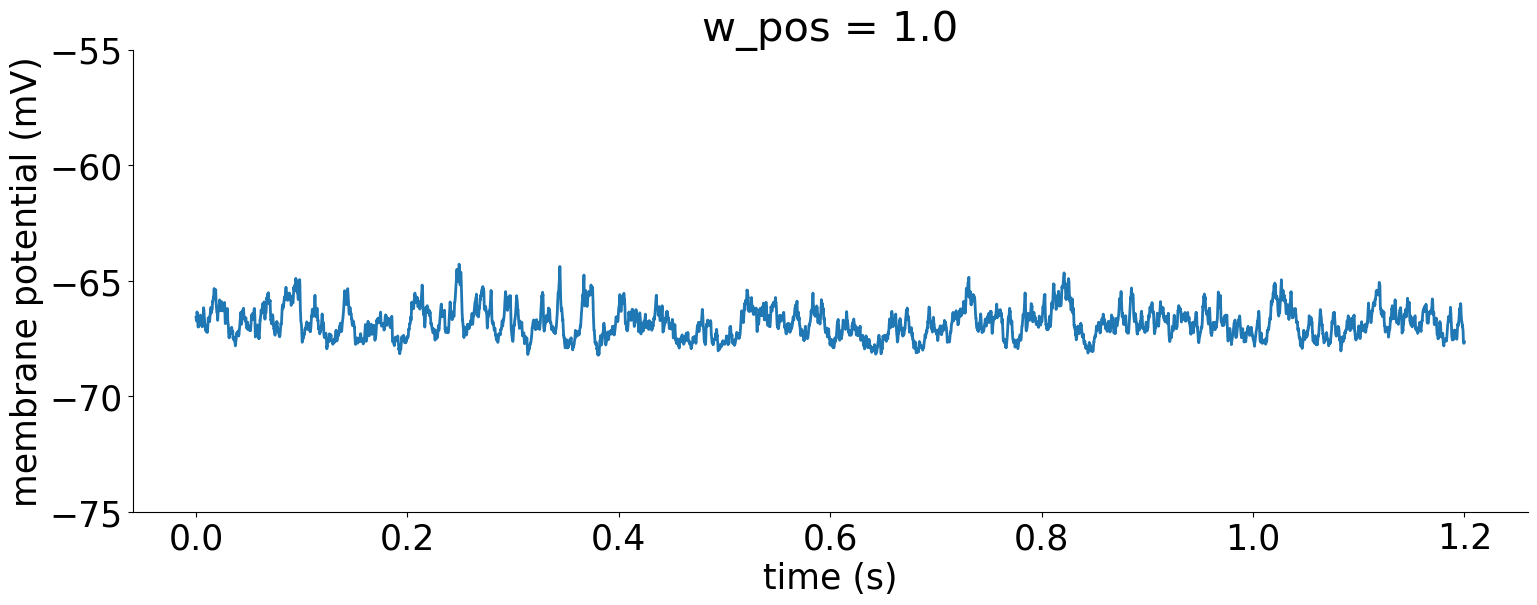

simulating 480 neurons. Start: Fri Nov  4 12:03:58 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


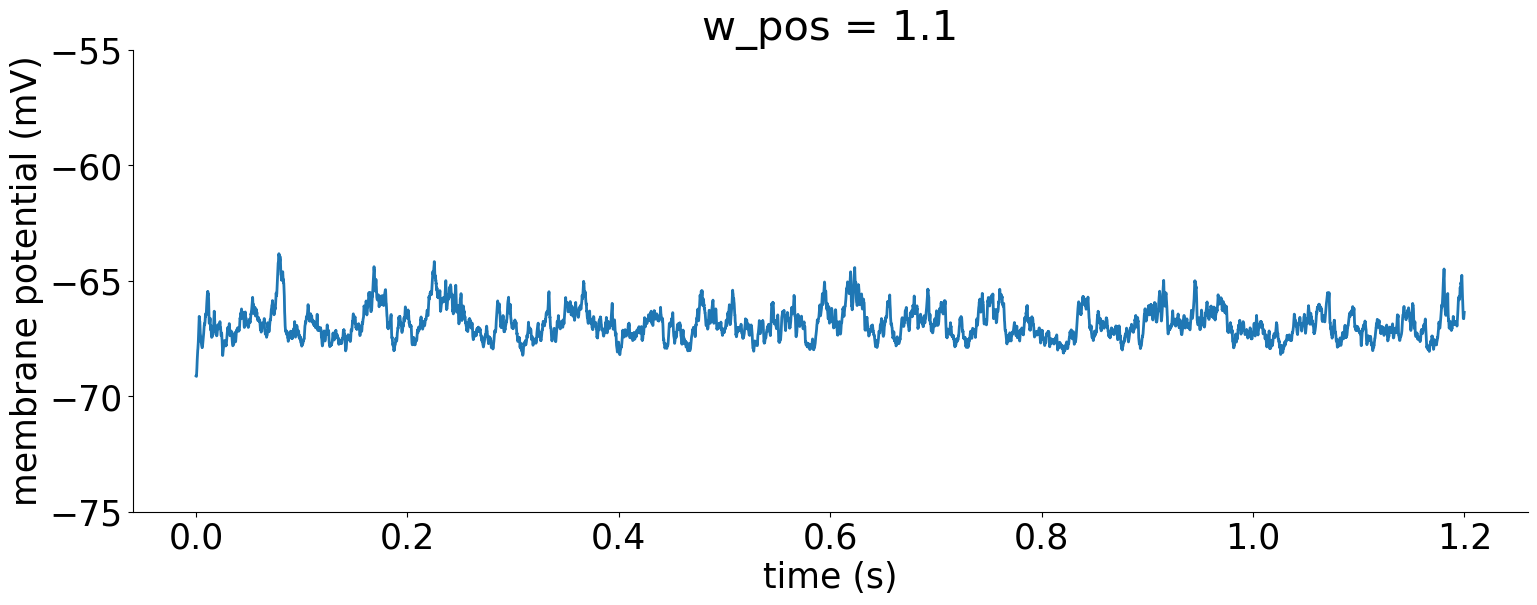

simulating 480 neurons. Start: Fri Nov  4 12:04:00 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


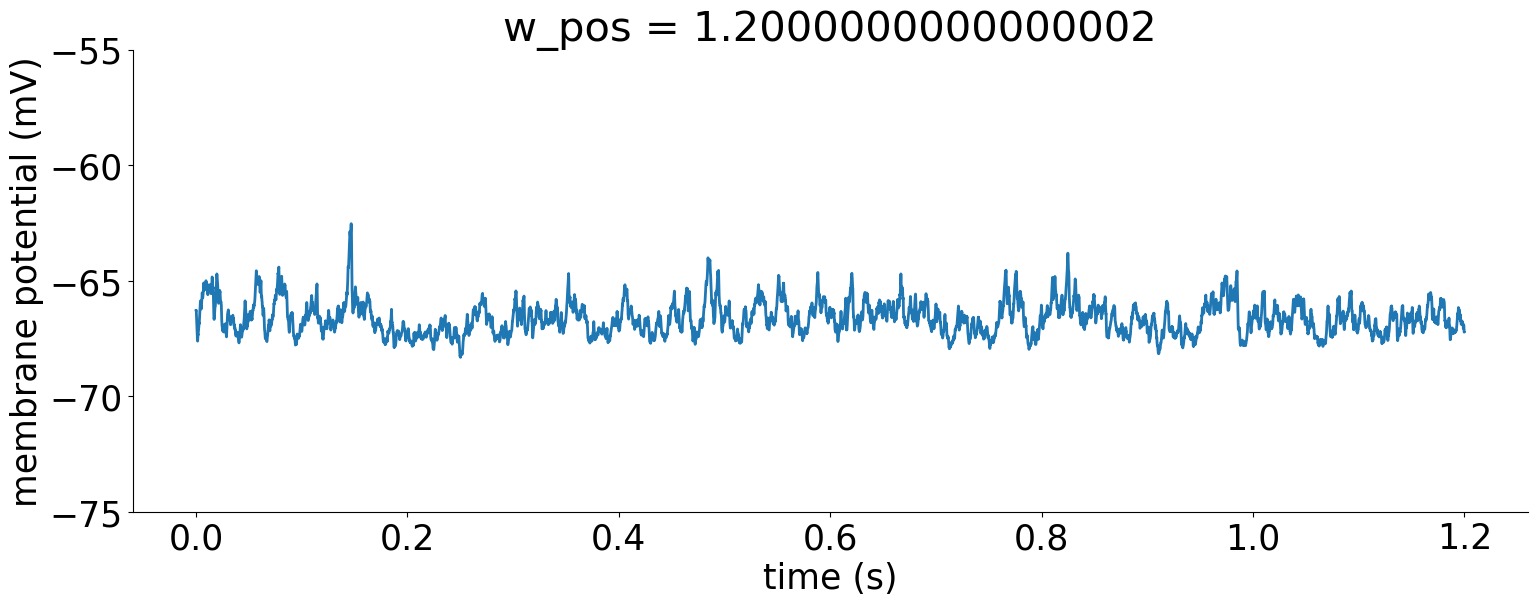

simulating 480 neurons. Start: Fri Nov  4 12:04:02 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


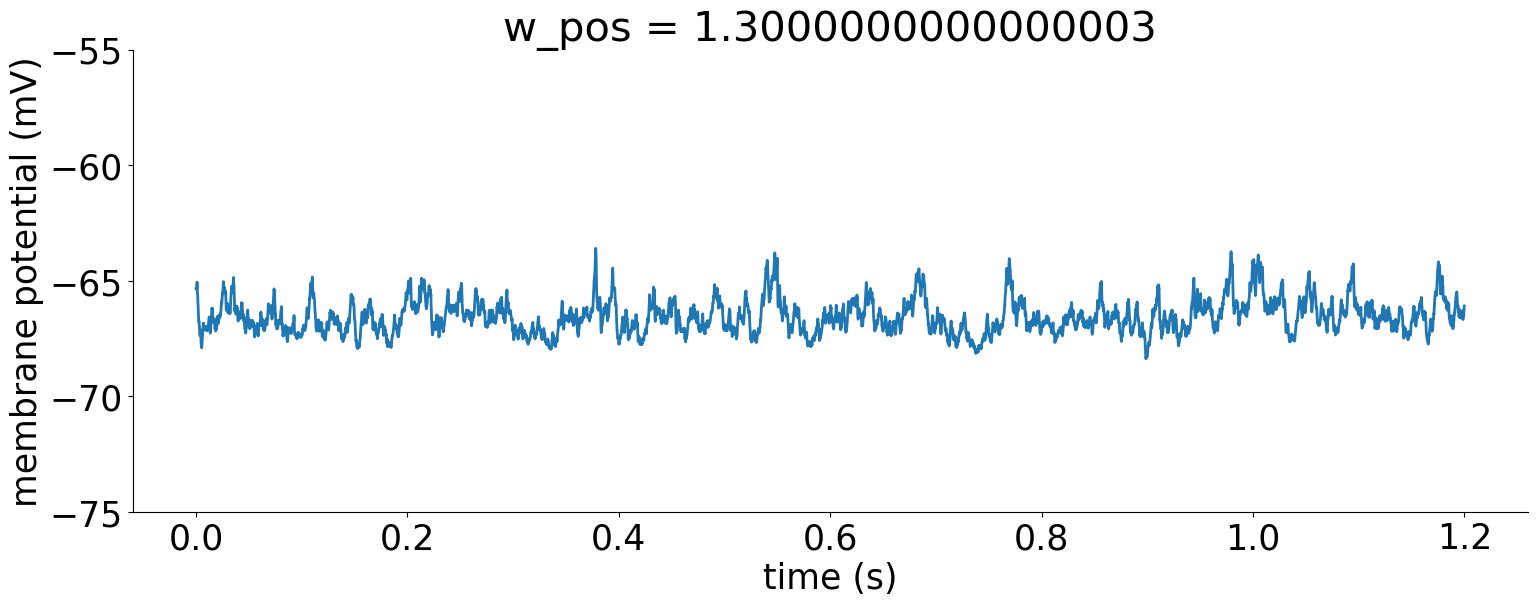

simulating 480 neurons. Start: Fri Nov  4 12:04:04 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


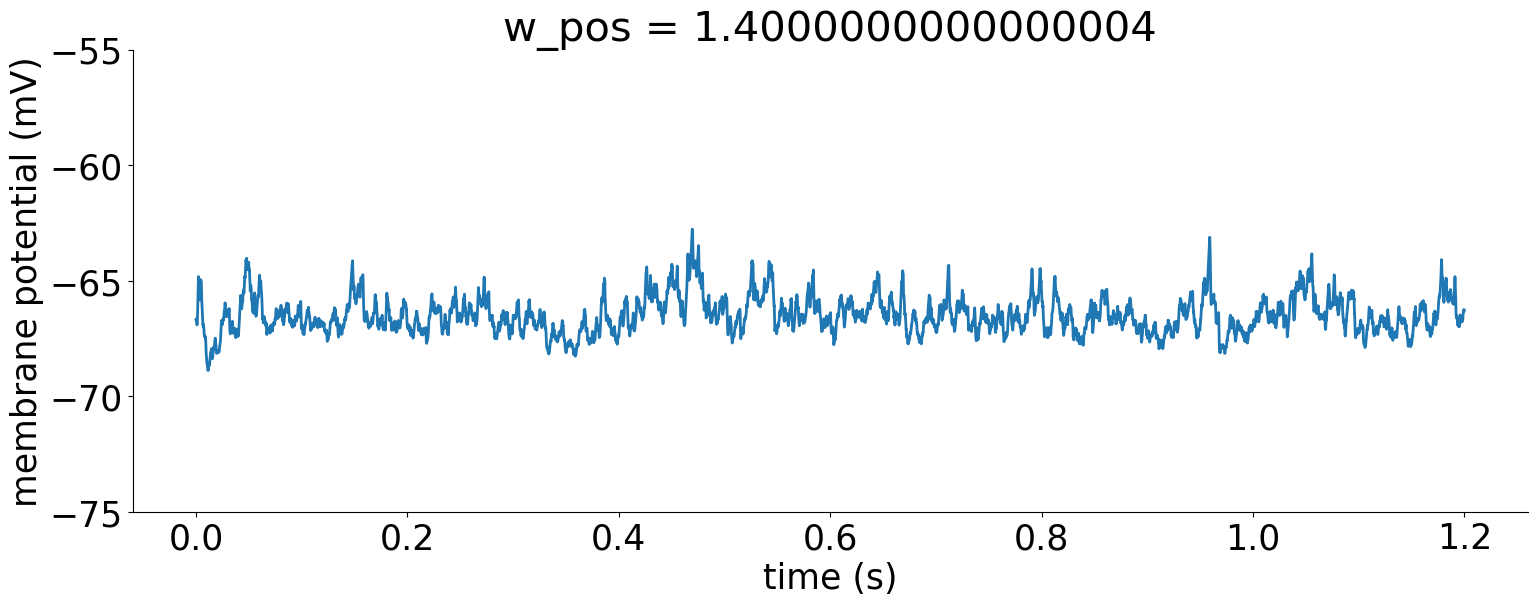

simulating 480 neurons. Start: Fri Nov  4 12:04:06 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


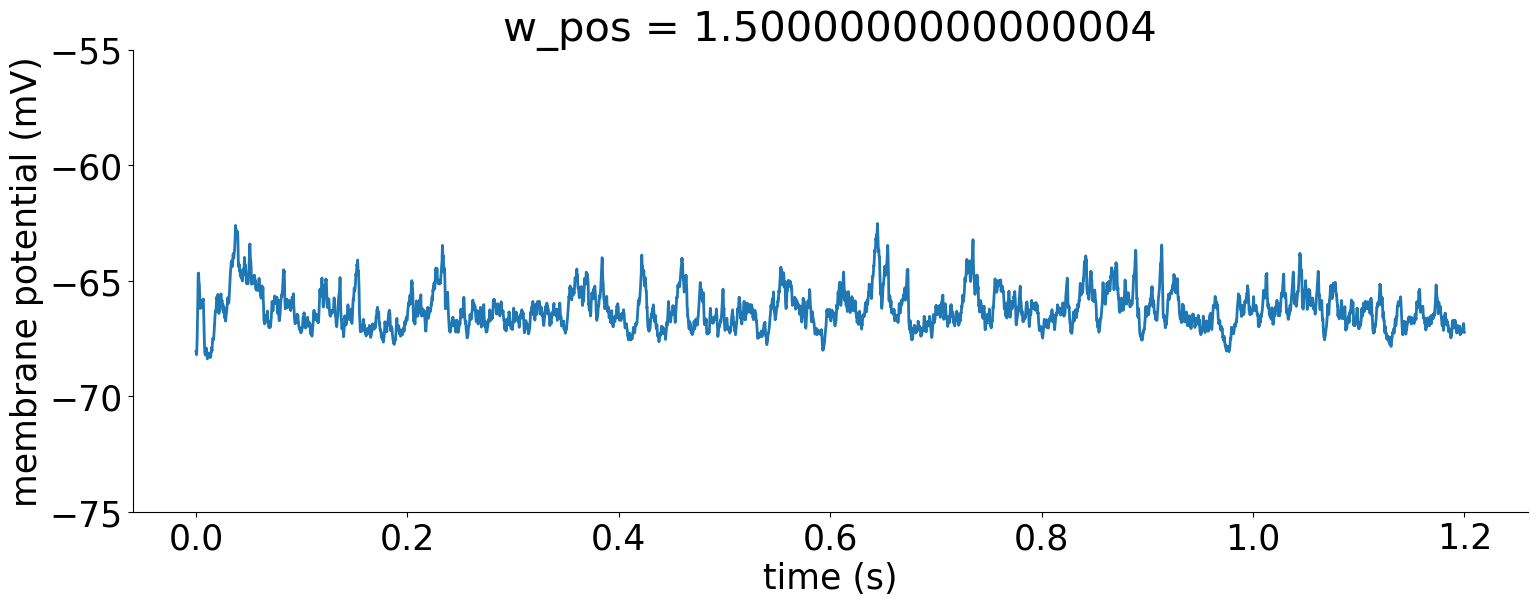

simulating 480 neurons. Start: Fri Nov  4 12:04:08 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


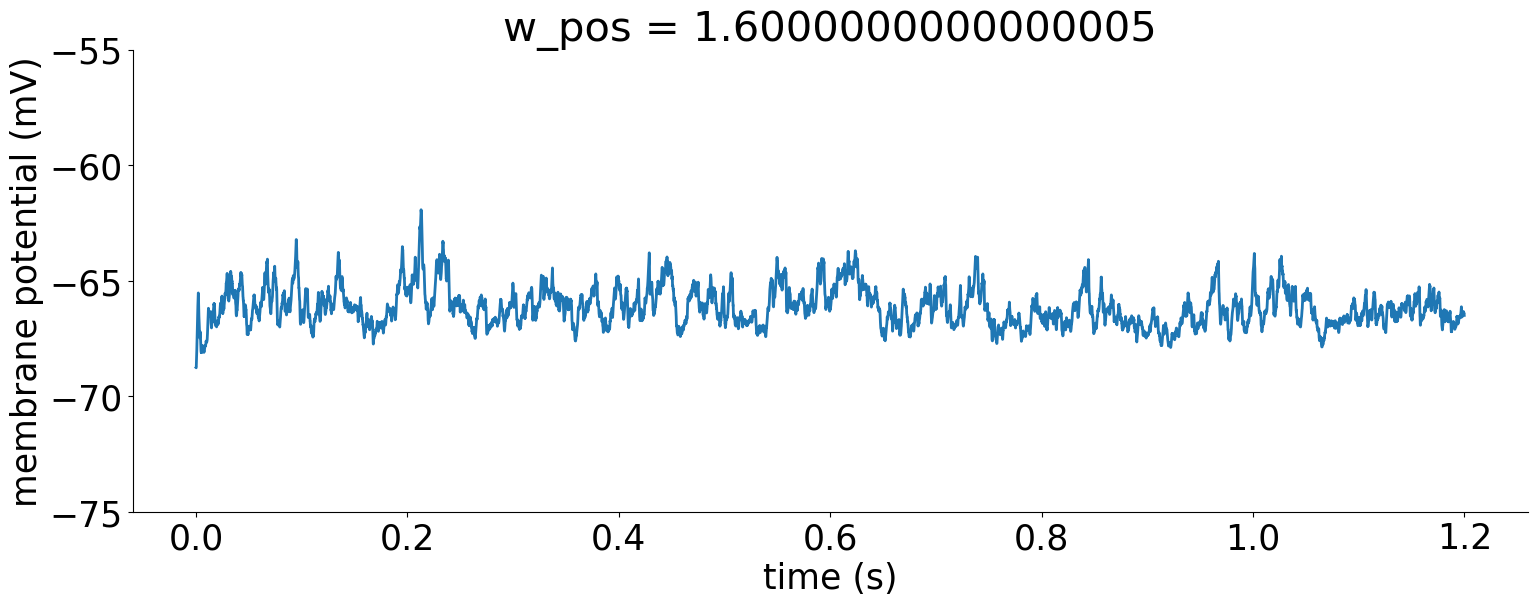

simulating 480 neurons. Start: Fri Nov  4 12:04:10 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


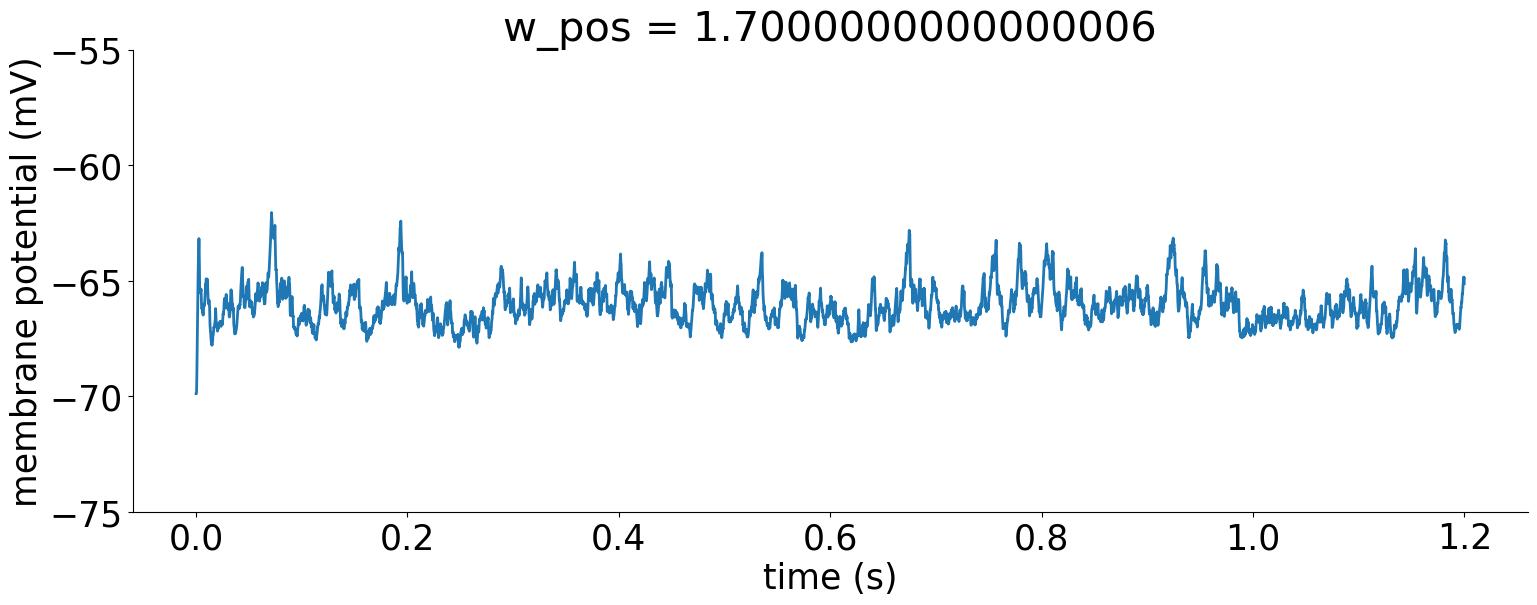

simulating 480 neurons. Start: Fri Nov  4 12:04:12 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


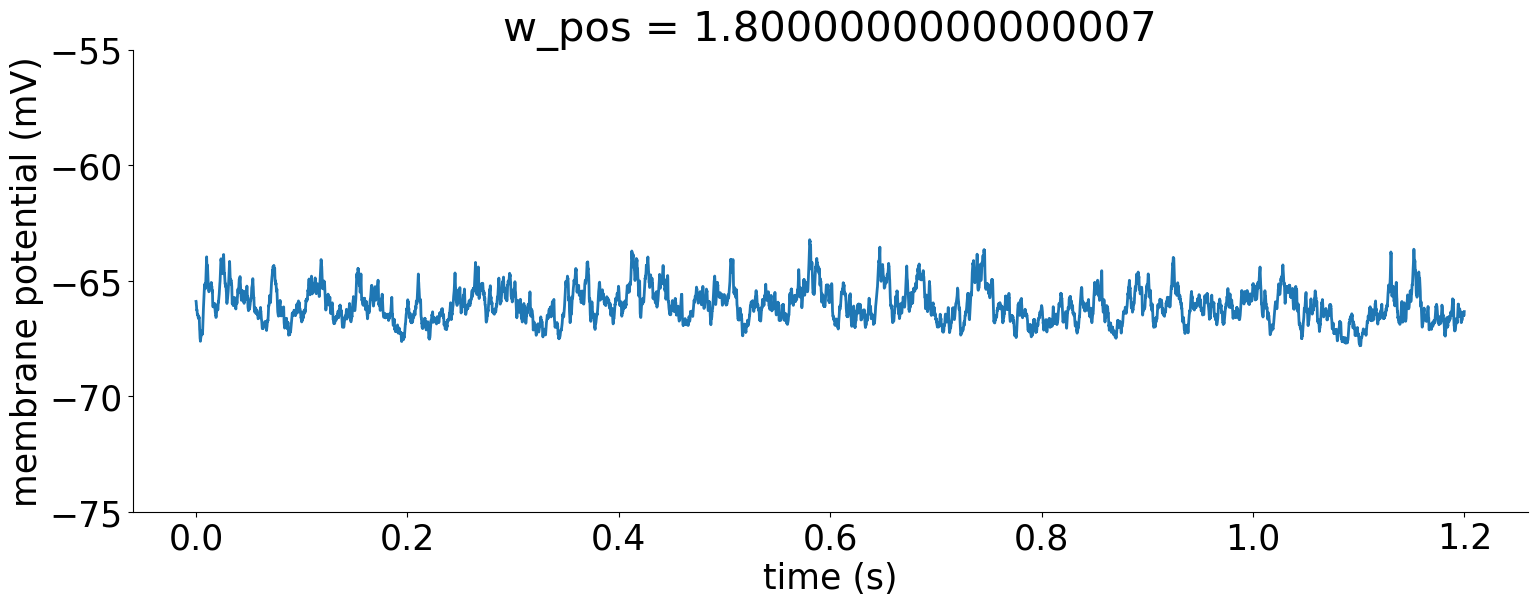

simulating 480 neurons. Start: Fri Nov  4 12:04:14 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


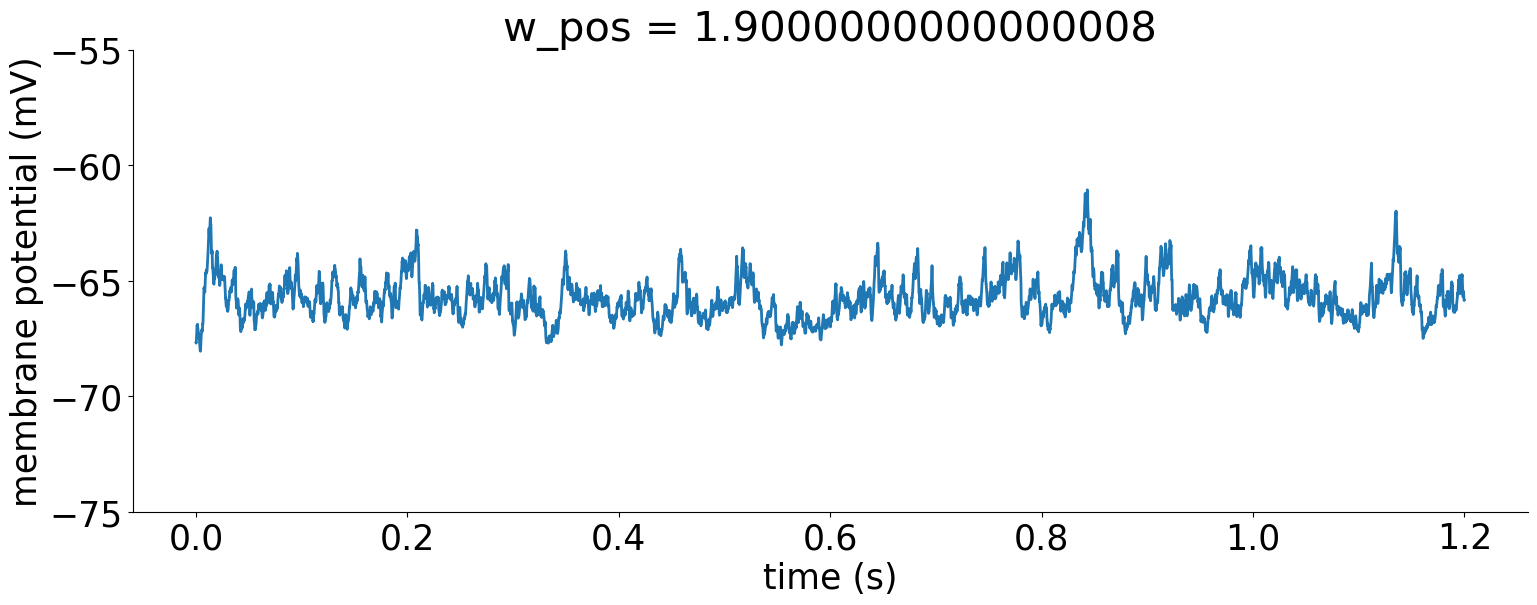

simulating 480 neurons. Start: Fri Nov  4 12:04:16 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


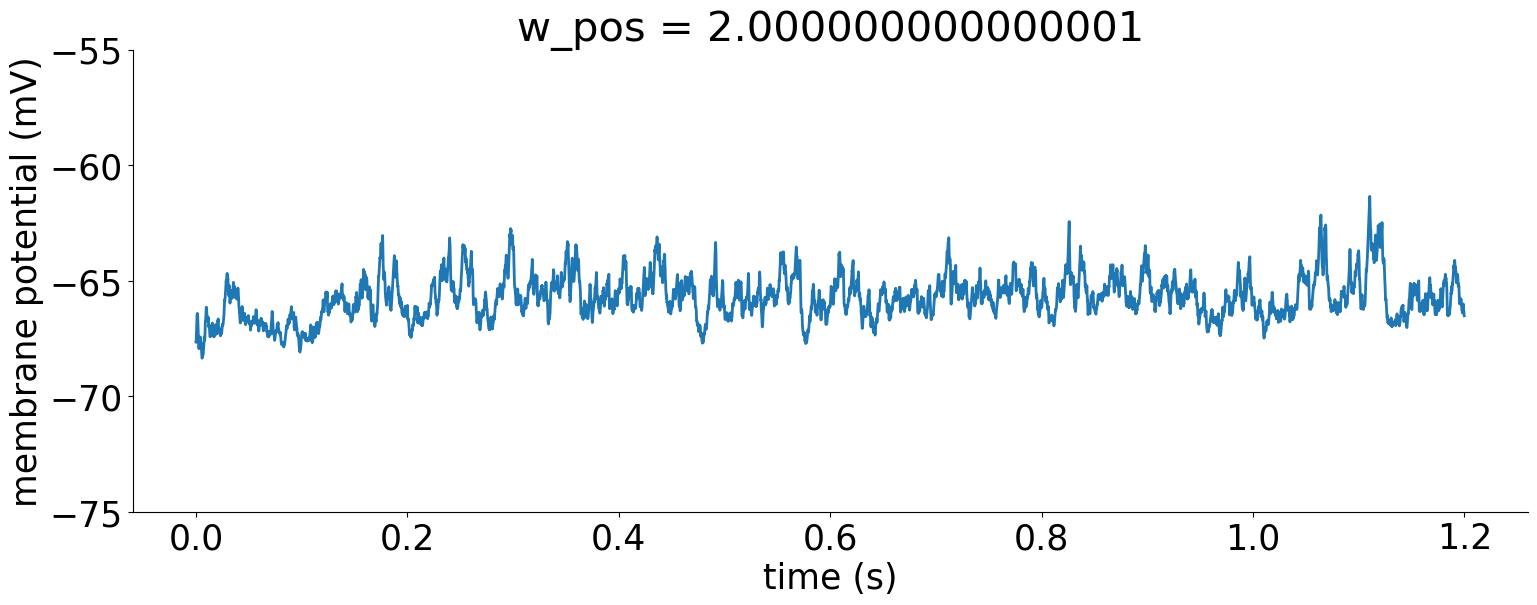

simulating 480 neurons. Start: Fri Nov  4 12:04:18 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


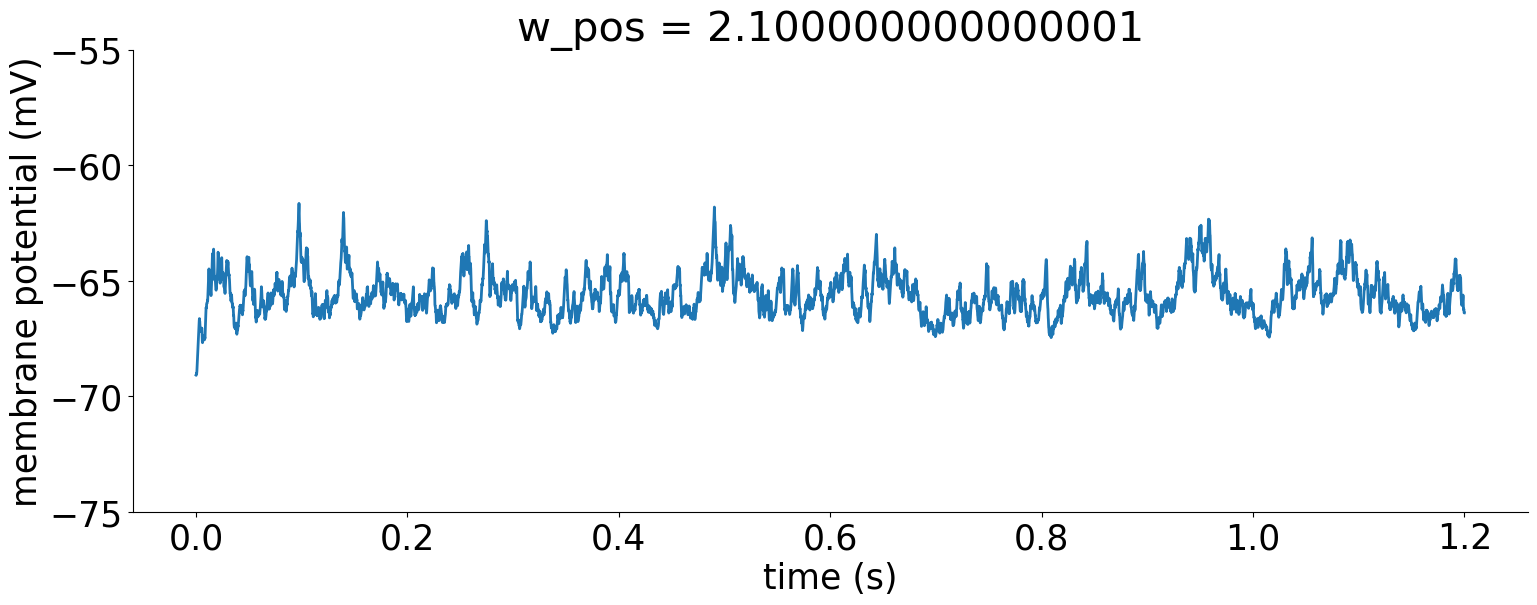

simulating 480 neurons. Start: Fri Nov  4 12:04:20 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


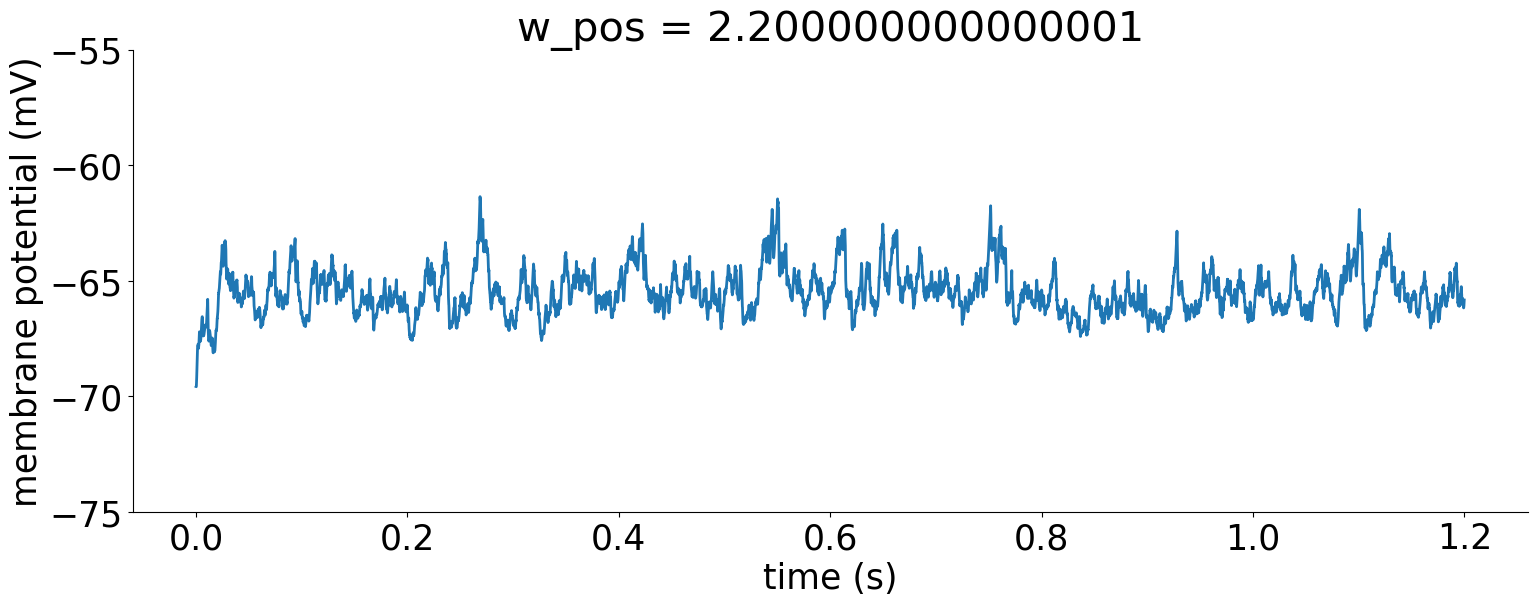

In [47]:
for w in w_pos:
    nmda_by_x(100, w)
    

simulating 480 neurons. Start: Fri Nov  4 12:01:31 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


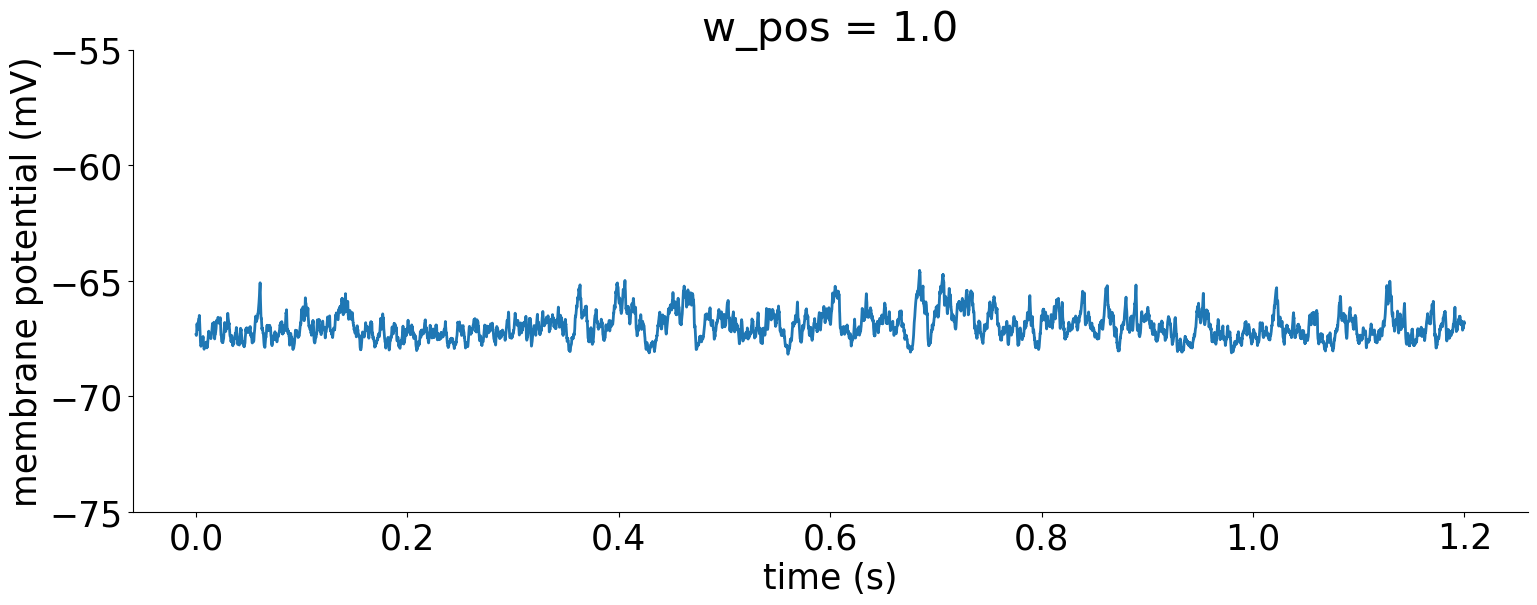

In [40]:
nmda_by_x(100, 1.0)

simulating 480 neurons. Start: Fri Nov  4 11:57:24 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


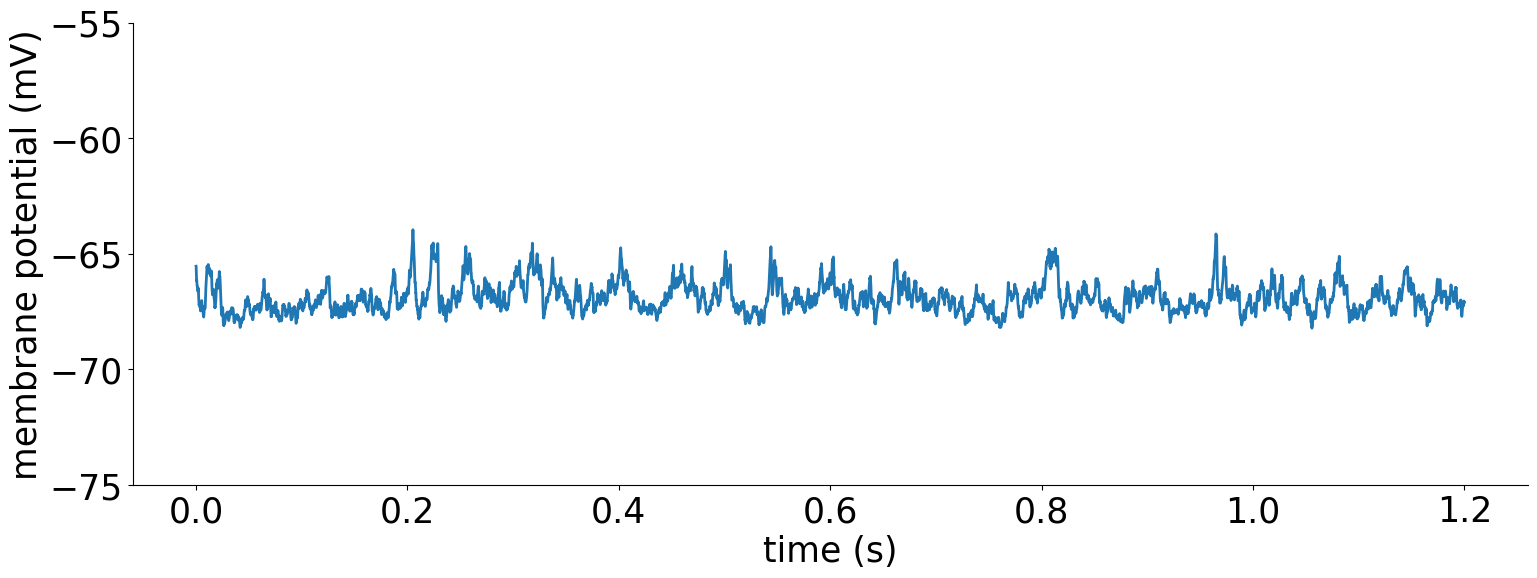

In [31]:
nmda_by_x(100, 1.0)

simulating 480 neurons. Start: Fri Nov  4 11:46:10 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


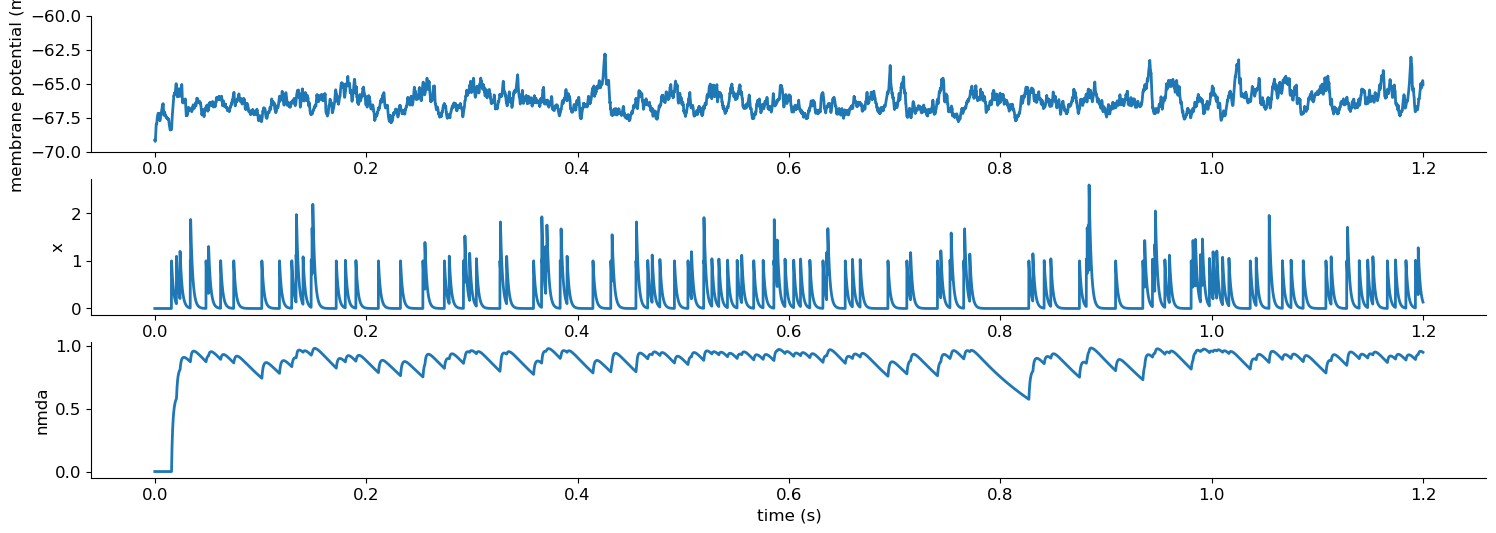

In [5]:
nmda_by_x(100, 1.5)

simulating 480 neurons. Start: Fri Nov  4 11:46:16 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


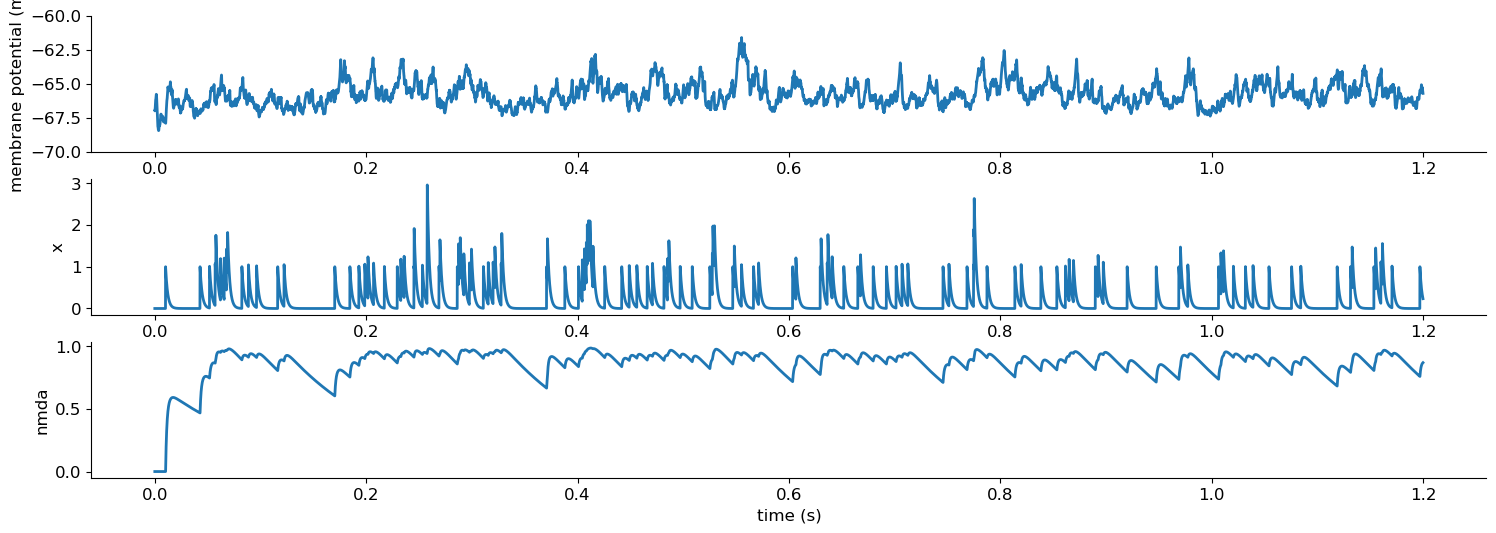

In [6]:
nmda_by_x(100, 1.9)